In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage
import math
from pprint import pprint
import random

In [4]:
class Cluster:
    def __init__(self, identifier, val=None, right=None, left=None):
        self.identifier = identifier
        self.val = val
        self.number_of_nodes = right.number_of_nodes + left.number_of_nodes if left and right else 1
        self.right = right
        self.left = left

def preorder(root:Cluster):
    if root:
        preorder(root.right)
        print(nodes(root))
        preorder(root.left)

def nodes(cluster:Cluster):
    if not cluster.left and not cluster.right:
        return [cluster.val]
    else:
        return nodes(cluster.right) + nodes(cluster.left)

def merge(clusterA:Cluster, clusterB:Cluster, identifier):
    return Cluster(identifier, right=clusterA, left=clusterB)

dist_matrix = {}
def euclidean_dist(x,y):
    if((x,y) not in dist_matrix):
        dist_matrix[(x,y)]=  math.sqrt((y[1] - x[1])**2 + (y[0] - x[0])**2)
    return dist_matrix[(x,y)]

def dist(clusterA:Cluster, clusterB:Cluster):
    nodesA = nodes(clusterA)
    nodesB = nodes(clusterB)
    min_dist = float("inf")
    for nodeA in nodesA:
        for nodeB in nodesB:
            min_dist = min(euclidean_dist(nodeA, nodeB), min_dist)
    return min_dist

def tie_breaker(list_of_clusters):
    return sorted(list_of_clusters, key=lambda i:(i[0].identifier, i[1].identifier))[0]

def clusters_with_min_dist(list_of_clusters):
    min_dist_between_clusters = float("inf")
    cluster_to_mergeB_index = None
    cluster_to_mergeA_index = None
    for i in range(len(list_of_clusters)):
        for j in range(i + 1, len(list_of_clusters)):
            clusterA = list_of_clusters[i]
            clusterB = list_of_clusters[j]
            d = dist(clusterA, clusterB)
            if d < min_dist_between_clusters:
                min_dist_between_clusters = d
                cluster_to_mergeA_index, cluster_to_mergeB_index = (i, j) if clusterA.identifier < clusterB.identifier else (j, i)
            elif d == min_dist_between_clusters: # Tie breaker
                t1, t2 = (i, j) if clusterA.identifier < clusterB.identifier else (j,i)
                if list_of_clusters[cluster_to_mergeA_index].identifier > list_of_clusters[t1].identifier:
                    cluster_to_mergeA_index = t1
                    cluster_to_mergeB_index = t2
                elif list_of_clusters[cluster_to_mergeA_index].identifier == list_of_clusters[t1].identifier:
                    if list_of_clusters[cluster_to_mergeB_index].identifier > list_of_clusters[t2].identifier:
                        cluster_to_mergeA_index = t1
                        cluster_to_mergeB_index = t2
    return (cluster_to_mergeA_index, cluster_to_mergeB_index, min_dist_between_clusters)

def hac(list_of_clusters):
    hac_table = []
    current_cluster_number = len(list_of_clusters) - 1
    while (len(list_of_clusters) > 1):
        c, d, dist_between_closest_clusters = clusters_with_min_dist(list_of_clusters)
        clusterA, clusterB = list_of_clusters[c], list_of_clusters[d]
        current_cluster_number += 1
        new_cluster = merge(clusterA=clusterA, clusterB=clusterB, identifier=current_cluster_number)
        number_of_nodes_in_merged_cluster = len(nodes(new_cluster))
        hac_table.append([clusterA.identifier, clusterB.identifier,
                          dist_between_closest_clusters, number_of_nodes_in_merged_cluster])
        list_of_clusters.append(new_cluster)
        if d > c:
            del list_of_clusters[d]
            del list_of_clusters[c]
        else:
            del list_of_clusters[c]
            del list_of_clusters[d]
    return np.array(hac_table), list_of_clusters[0]

def get_one_node_from_cluster_with_id(root:Cluster, identifier):
    if root:
        if root.identifier == identifier:
            return nodes(root)[0]
        else:
            return get_one_node_from_cluster_with_id(root.left, identifier) \
                   or get_one_node_from_cluster_with_id(root.right, identifier)
            


In [80]:
def random_x_y(m):
  return [(np.random.randint(1,360), np.random.randint(1,360)) for _ in range(m)]

random_x_y(3)

[(38, 37), (60, 260), (310, 43)]

In [ ]:
def load_data(filepath):
  with open(filepath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    ans = []
    for row in reader:

      row['#'] = int(row['#'])
      row['Total'] = int(row['Total'])
      row['HP'] = int(row['HP'])
      row['Attack'] = int(row['Attack'])
      row['Defense'] = int(row['Defense'])
      row['Sp. Atk'] = int(row['Sp. Atk'])
      row['Sp. Def'] = int(row['Sp. Def'])
      row['Speed'] = int(row['Speed'])
      del(row['Generation'])
      del(row['Legendary'])
      ans.append(dict(row))
      if len(ans)== 20:
        break
  
    return ans

a = load_data('sample_data/Pokemon.csv')
a

In [33]:
def calculate_x_y(stats):
  return (stats['Attack']+stats['Sp. Atk']+stats['Speed'], stats['Defense']+stats['Sp. Def']+stats['HP'])

calculate_x_y(a[-1])

(310, 185)

In [ ]:
pokemons =[]
for pokemon in a:
  pokemons.append(calculate_x_y(pokemon))
for i in range(len(pokemons)):
  print(i, pokemons[i])

In [47]:
list_of_clusters = []
for idx, pokemon in enumerate(pokemons):
  list_of_clusters.append(Cluster(identifier=idx, val=pokemon))
# pprint(vars(list_of_clusters[-1]))
hac_table, root = hac(list_of_clusters)
print(get_one_node_from_cluster_with_id(root, 33))
print(len(hac_table))
hac_table

(186, 219)
19


array([[ 7.        ,  8.        ,  4.24264069,  2.        ],
       [15.        , 18.        ,  7.07106781,  2.        ],
       [ 1.        , 21.        , 13.34166406,  3.        ],
       [13.        , 16.        , 14.14213562,  2.        ],
       [14.        , 17.        , 14.14213562,  2.        ],
       [ 5.        , 22.        , 14.56021978,  4.        ],
       [ 3.        , 12.        , 16.64331698,  2.        ],
       [23.        , 24.        , 22.36067977,  4.        ],
       [10.        , 25.        , 22.627417  ,  5.        ],
       [ 0.        ,  9.        , 22.8035085 ,  2.        ],
       [ 2.        , 11.        , 26.40075756,  2.        ],
       [ 4.        , 29.        , 32.44996148,  3.        ],
       [ 6.        , 30.        , 38.01315562,  3.        ],
       [28.        , 31.        , 55.47071299,  8.        ],
       [19.        , 32.        , 58.52349955,  4.        ],
       [20.        , 26.        , 59.46427499,  4.        ],
       [34.        , 35.

In [42]:
x = []
y = []
for row in hac_table:
    a = get_one_node_from_cluster_with_id(root, row[0])
    b = get_one_node_from_cluster_with_id(root, row[1])
    x += [a[0], b[0]]
    y += [a[1], b[1]]

# x = sorted(x)
# y = sorted(y)
print(x)
# print(y)

expectedX = []
expectedY = []
for i in pokemons:
  expectedX.append(i[0])
  expectedY.append(i[1])

expectedX = sorted(expectedX)
# y = sorted(y)

# print(expectedX)

[360, 363, 205, 210, 202, 205, 95, 105, 75, 85, 224, 202, 302, 316, 95, 75, 186, 224, 159, 141, 262, 246, 177, 159, 293, 262, 186, 177, 310, 293, 360, 302, 310, 360, 95, 186, 310, 95]


205 190


TypeError: ignored

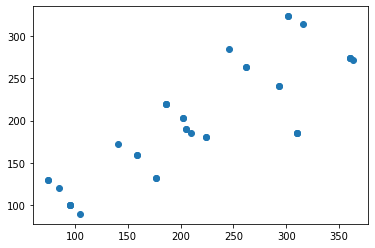

In [63]:

a = [x[0], x[1]]
b = [y[0], y[1]]

a = set(a)
b = set(b)

# a = x[:5]
# b = y[:5]

# plt.plot(a, b)

for i in range(2, len(x)):
  plt.scatter(x, y)
  print(x[i], y[i])
  a.add(x[i])
  b.add(y[i])
  # plt.plot(list(a), list(b))
  plt.plot(a,b)
  plt.pause(0.1)

# plt.show()

In [53]:
# X = [[i] for i in [0, 1, 2, 4, 6]]
# plt.plot(X)
# print()
# plt.scatter(X[:], y)
Z = linkage(pokemons, 'single')
Z

array([[ 7.        ,  8.        ,  4.24264069,  2.        ],
       [15.        , 18.        ,  7.07106781,  2.        ],
       [ 1.        , 21.        , 13.34166406,  3.        ],
       [14.        , 17.        , 14.14213562,  2.        ],
       [13.        , 16.        , 14.14213562,  2.        ],
       [ 5.        , 22.        , 14.56021978,  4.        ],
       [ 3.        , 12.        , 16.64331698,  2.        ],
       [23.        , 24.        , 22.36067977,  4.        ],
       [10.        , 25.        , 22.627417  ,  5.        ],
       [ 0.        ,  9.        , 22.8035085 ,  2.        ],
       [ 2.        , 11.        , 26.40075756,  2.        ],
       [ 4.        , 29.        , 32.44996148,  3.        ],
       [ 6.        , 30.        , 38.01315562,  3.        ],
       [28.        , 31.        , 55.47071299,  8.        ],
       [19.        , 32.        , 58.52349955,  4.        ],
       [20.        , 26.        , 59.46427499,  4.        ],
       [34.        , 35.

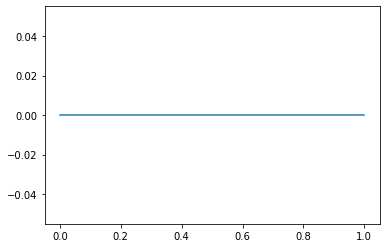

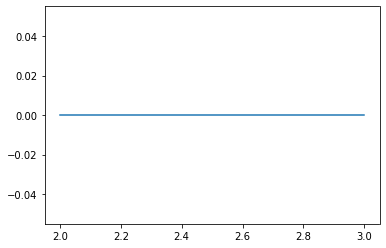

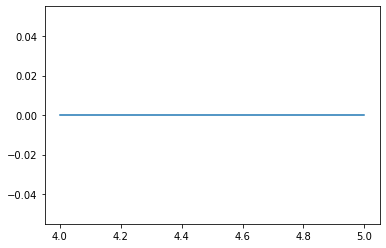

In [70]:
y = [0,0,0,0,0,0]
x = [0,1,2,3,4,5]

for i in range(0, len(x), 2):
  plt.plot(x[i:i+2],y[i:i+2])
  plt.pause(1)
  

**Playground**

In [ ]:
X = [[i] for i in [0, 1, 2, 4, 6]]
plt.plot(X)
# print()
# plt.scatter(X[:], y)
Z = linkage(X, 'single')
Z

In [ ]:
X = [[1,0], [3,10], [5, 34], [16,0]]
# plt.plot(X)
# print()
# plt.scatter(X[:], y)
Z = linkage(X, 'single')
Z

array([[ 0.        ,  1.        , 10.19803903,  2.        ],
       [ 3.        ,  4.        , 15.        ,  3.        ],
       [ 2.        ,  5.        , 24.08318916,  4.        ]])

In [ ]:
np.array(X)

array([[ 1,  0],
       [ 3, 10],
       [ 5, 34],
       [16,  0]])

In [ ]:
x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
print(x[0:2])
for i in range(1, len(x)+1):
  plt.scatter(x, y)
  plt.plot(x[0:i], y[0:i], c=np.random.rand(3,))
  plt.plot(x[i:i+2], y[i:i+2], c=np.random.rand(3,))
  plt.pause(0.1)
  plt.show()


Text(0.5, 1.0, 'Simple Plot')

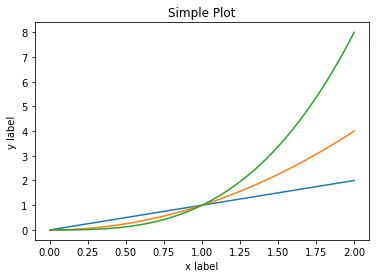

In [ ]:
x = np.linspace(0, 2, 100)

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, x, label='linear')  # Plot some data on the axes.
ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
ax.plot(x, x**3, label='cubic')  # ... and some more.
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.


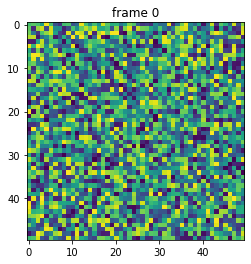

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)
data = np.random.random((50, 50, 50))

fig, ax = plt.subplots()
# fig vs ax vs plt ? 
for i in range(len(data)):
    ax.cla()
    ax.imshow(data[i])
    ax.set_title("frame {}".format(i))
    # Note that using time.sleep does *not* work here!
    plt.pause(0.1)
    plt.show()

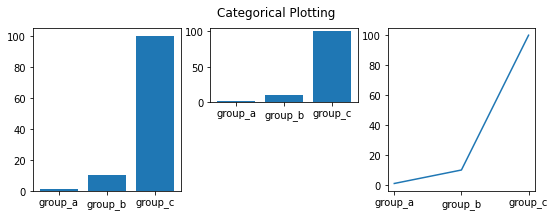

In [ ]:
names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.subplot(232)
plt.bar(names, values)
plt.show()


In [ ]:
# Implementation of matplotlib function
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19)
data = np.random.random((5, 10, 10))


for i in range(len(data)):
	plt.cla()
	plt.title('matplotlib.pyplot.pause() function Example\n\n Window {}'.format(i), fontweight ="bold")
	plt.imshow(data[i])
	plt.pause(0.1)


In [ ]:
# Implementation of matplotlib function
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19)
data = np.random.random((5, 10, 10))


for i in range(len(data)):
	plt.cla()
	plt.title('matplotlib.pyplot.pause() function Example\n\n Window {}'.format(i), fontweight ="bold")
	plt.imshow(data[i])
	plt.pause(0.1)


In [76]:
np.isinf(float(3))

False